# 3
- extract a feature vector for an image
- KMeans, AgglomerativeClustering
- PCA, TruncatedSVD

In [1]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torchsummary import summary
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
path = 'W:\\datasets\\asbestos\\line-segmentation\\'
os.listdir(path)

['aug_images_224',
 'aug_masks_224',
 'images',
 'images_encoder',
 'images_encoder0',
 'images_encoder1',
 'macro_fullsize.xml',
 'masks',
 'masks_encoder',
 'v1']

In [4]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'images_encoder':
        img_pathes = pathes
    elif folder == 'masks_encoder':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

In [5]:
img_pathes

['W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\DSC05086_5.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\DSC05090_1.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\DSC05090_13.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\DSC05090_18.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\DSC05091_1.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\IMG_2638_2.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\IMG_2644_17.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\IMG_2645_14.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\IMG_2645_6.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\IMG_2647_12.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\IMG_2648_11.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\IMG_2648_12.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encod

In [31]:
def get_vectors(model = 'resnet34'):
    if model == 'resnet18':
        model = models.resnet18(pretrained=True)
    elif model == 'resnet34':
        model = models.resnet34(pretrained=True)
    elif model == 'resnet50':
        model = models.resnet50(pretrained=True)
    elif model == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
    elif model == 'densenet201':
        model = models.densenet201(pretrained=True)
    elif model =='alexnet':
        model = models.alexnet(pretrained=True)
    elif model == 'resnet152':
        model = models.resnet152(pretrained=True)
    elif model == 'resnext101_32x8d':
        model = models.resnext101_32x8d(pretrained=True)
    elif model == 'squeezenet1_1':
        model = models.squeezenet1_1(pretrained=True)
    elif model == 'wide_resnet101_2':
        model = models.wide_resnet101_2(pretrained=True)  
    elif model == 'vgg16':
        model = models.vgg16(pretrained=True)    
        
    #model = models.resnet34(pretrained=True)
    model.eval()

    scaler = transforms.Resize((224, 224))
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    to_tensor = transforms.ToTensor()

    ### strip the last layer
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1]) #magic
    vectors = []
    for i in img_pathes:
        img = Image.open(i)
        t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
        vectors.append(feature_extractor(t_img).view(-1).detach().numpy())
    return vectors

In [7]:
#summary(model.cuda(), (3, 224, 224))

In [8]:
answers = [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]

# KMeans & AgglomerativeClustering

In [9]:
def kmeans_ac(vectors):
    print(answers, "gt   ")
    kmeans = KMeans(n_clusters=2, random_state=42).fit(vectors)
    predictions = kmeans.labels_
    eq = sum(predictions == answers)
    neq = sum(predictions != answers)

    print(list(predictions), " KMeans ", eq,"-", neq)

    ac = AgglomerativeClustering(n_clusters=2).fit(vectors)
    predictions = ac.labels_
    eq = sum(predictions == answers)
    neq = sum(predictions != answers)
    print(list(predictions), " AgglomerativeClustering", eq,"-", neq)


# PCA & SVD

In [10]:
def plot_PCA_SVD(vectors): 
    x1_pca, y1_pca, x2_pca, y2_pca = PCA_SVD(vectors, 'pca')
    x1_svd, y1_svd, x2_svd, y2_svd = PCA_SVD(vectors, 'svd')

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('PCA')
    plt.scatter(x1_pca, y1_pca, label='1')
    plt.scatter(x2_pca, y2_pca, label='0')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title('SVD')
    plt.scatter(x1_svd, y1_svd, label='1')
    plt.scatter(x2_svd, y2_svd, label='0')
    
    plt.legend()
    plt.show()

In [11]:
def PCA_SVD(vectors, alg):
    if alg == 'pca':
        pca = PCA(n_components=2, random_state=42).fit(vectors)
        print("PCA explained variance ratio ", pca.explained_variance_ratio_)
        print("PCA singular values          ", pca.singular_values_)
        X = pca.transform(vectors)
    elif alg == 'svd':
        svd = TruncatedSVD(n_components=2, random_state=42).fit(vectors)
        print("SVD explained variance ratio ", svd.explained_variance_ratio_)
        print("SVD singular values          ", svd.singular_values_)
        X = svd.transform(vectors)
    x1, x2, y1, y2 = [], [], [], []
    for i, (xi, yi) in enumerate(zip(X[:, 0], X[:, 1])):
        (x1.append(xi), y1.append(yi)) if answers[i] else (x2.append(xi), y2.append(yi))
    return x1, y1, x2, y2

# nets

===== resnet18 =====
PCA explained variance ratio  [0.2970826  0.17724557]
PCA singular values           [20.36079353 15.72692381]
SVD explained variance ratio  [0.08398411 0.2648128 ]
SVD singular values           [81.72535  19.268442]


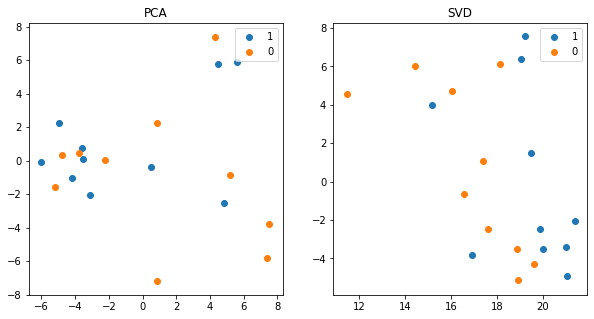

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0] gt   
[0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]  KMeans  12 - 8
[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]  AgglomerativeClustering 11 - 9
===== resnet34 =====
PCA explained variance ratio  [0.28001075 0.17042026]
PCA singular values           [23.21424587 18.11039161]
SVD explained variance ratio  [0.09198841 0.26128688]
SVD singular values           [94.61514  22.451817]


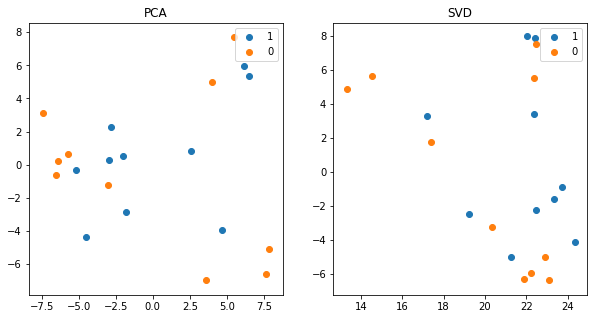

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0] gt   
[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]  KMeans  11 - 9
[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]  AgglomerativeClustering 12 - 8
===== resnet50 =====
PCA explained variance ratio  [0.35019902 0.12337339]
PCA singular values           [27.37553365 16.24859743]
SVD explained variance ratio  [0.10062129 0.2884445 ]
SVD singular values           [98.746056 24.98672 ]


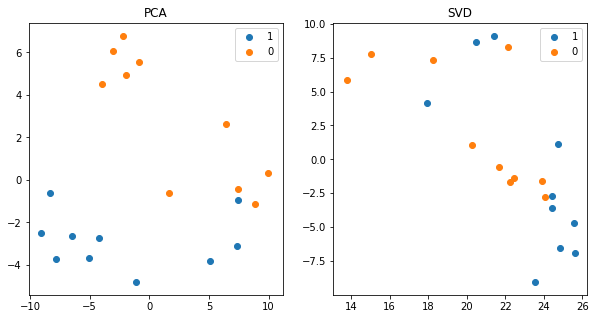

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0] gt   
[0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]  KMeans  8 - 12
[0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]  AgglomerativeClustering 8 - 12
===== mobilenet_v2 =====
PCA explained variance ratio  [0.14624221 0.12025276]
PCA singular values           [172.67961287 156.58574245]
SVD explained variance ratio  [0.0253737  0.13733485]
SVD singular values           [538.7007  167.67502]


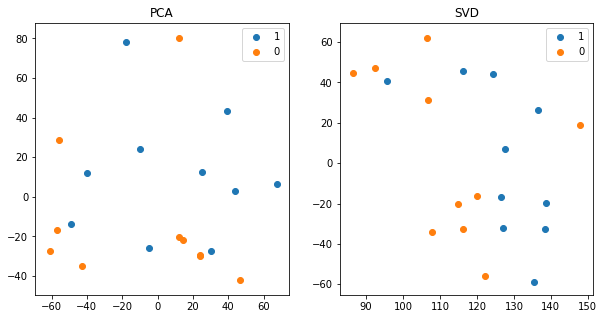

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0] gt   
[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]  KMeans  11 - 9
[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]  AgglomerativeClustering 12 - 8
===== densenet201 =====
PCA explained variance ratio  [0.12142566 0.0952886 ]
PCA singular values           [265.73500224 235.40408986]
SVD explained variance ratio  [0.01774163 0.11574695]
SVD singular values           [695.95404 260.1464 ]


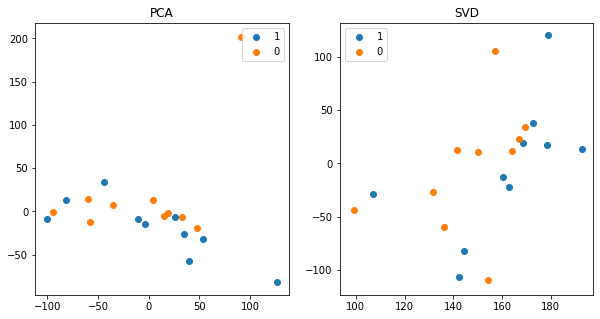

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0] gt   
[0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1]  KMeans  9 - 11
[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]  AgglomerativeClustering 10 - 10
===== alexnet =====
PCA explained variance ratio  [0.16617754 0.09307983]
PCA singular values           [98.59449894 73.78945729]
SVD explained variance ratio  [0.04487508 0.14079401]
SVD singular values           [298.59567  91.36128]


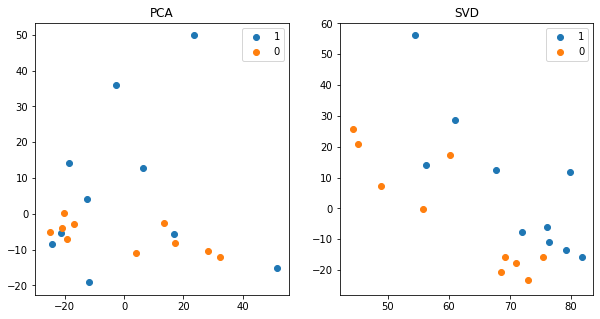

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0] gt   
[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]  KMeans  11 - 9
[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]  AgglomerativeClustering 10 - 10
===== resnet152 =====
PCA explained variance ratio  [0.24174249 0.17545115]
PCA singular values           [25.40242624 21.64097445]
SVD explained variance ratio  [0.08414663 0.24057037]
SVD singular values           [101.64844  25.34262]


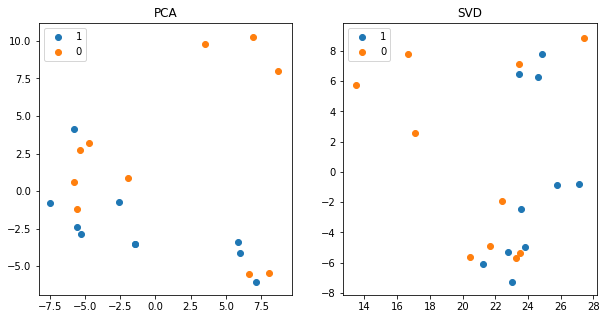

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0] gt   
[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]  KMeans  9 - 11
[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]  AgglomerativeClustering 12 - 8
===== resnext101_32x8d =====
PCA explained variance ratio  [0.25649645 0.16108624]
PCA singular values           [31.13007657 24.66997639]
SVD explained variance ratio  [0.08577554 0.21775219]
SVD singular values           [115.62598   28.783976]


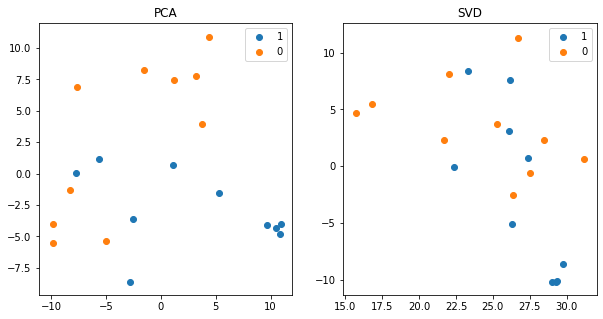

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0] gt   
[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]  KMeans  11 - 9
[0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]  AgglomerativeClustering 10 - 10
===== wide_resnet101_2 =====
PCA explained variance ratio  [0.27549703 0.14316472]
PCA singular values           [26.71306803 19.25676406]
SVD explained variance ratio  [0.04075693 0.2576749 ]
SVD singular values           [97.82517 25.89041]


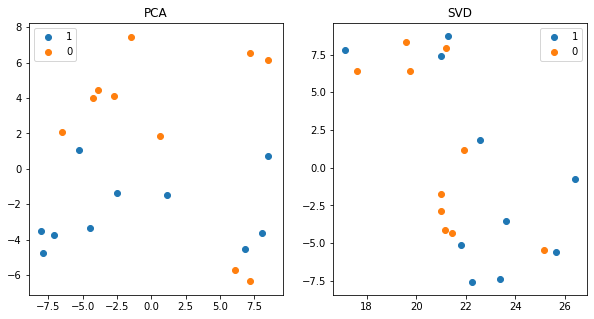

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0] gt   
[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]  KMeans  11 - 9
[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]  AgglomerativeClustering 12 - 8
===== vgg16 =====
PCA explained variance ratio  [0.13506419 0.08547339]
PCA singular values           [87.77098897 69.82265308]
SVD explained variance ratio  [0.04700382 0.10645553]
SVD singular values           [225.70325  78.78138]


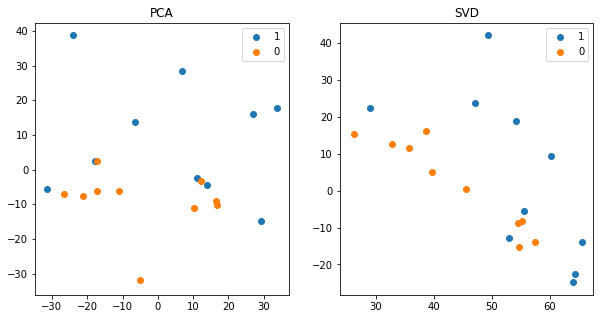

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0] gt   
[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]  KMeans  10 - 10
[0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1]  AgglomerativeClustering 8 - 12
Wall time: 3min 23s


In [30]:
%%time
for i in ['resnet18', 'resnet34', 'resnet50', 'mobilenet_v2', 'densenet201', 'alexnet', 'resnet152', 'resnext101_32x8d', 'wide_resnet101_2', 'vgg16']:
    print("=====", i, "=====")
    vectors = get_vectors(i)
    plot_PCA_SVD(vectors)
    kmeans_ac(vectors)